Time series는 temporal dimension을 가지고 있으며 financial data에서 가장 상징적 형태라 볼 수 있다. 
이번에는 신경망이 어떻게 Time series를 다루는지 볼 것이고 dl 모델이 어떻게 불확실성을 표현할 수 있는지 볼 것이다.

Time series에 들어가기 앞서 대부분 주식 시장 예측이라는 주제를 기대하겠지만 이책에서는 해당 주제를 다루지 않을 것이다.  경제학에서 시장은 효율적이다. 효율적 시장 가설은 모든 대중이 주가와 관련된 정보를 이용할 수 있다고 주장한다. 이 내용은 예측 알고리즘이 어떻게 정보를 다뤄야하는지에 대한 것으로 이어진다. 

만약 이 책에서 수익 모델을 만든다면 많은 투자자들은 이 알고리즘을 구현할 것이다. 이 알고리즘으로 인해 시장 예측에 관한 모든 변수가 바뀐다. 그렇기에 이 책에서 제시한 알고리즘이 앞으로 읽을 독자들에게는 먹히지 않을 것이다.

대신에 이 챕터에서는 위키피디아에서 트래픽 데이터를 사용할 것이다. 우리의 목표는 특정 위키피디아 페이지의 트래픽을 예측하는 것이다. wikipediatrend CRAN package에서 위키피디아 트래픽 데이터를 구할 수 있다.

여기에서 쓸 데이터셋은 145000여개의 위키피디아 페이지가 있다. 데이터를 캐글에서 구할 수 있다.

데이터셋 링크:www.kaggle.com/c/web-traffic-time-series-forecasting

### Visualization and preparation in pandas

Applying Machine Learning to Structured Data에서 봤듯이, 학습 전에 데이터를 살펴보는 것이 좋다. 

In [3]:
import numpy as np
import pandas as pd

import os

In [4]:
print(os.listdir("../input"))

['key_1.csv', 'key_2.csv', 'sample_submission_1.csv', 'sample_submission_2.csv', 'train_1.csv', 'train_2.csv']


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [6]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

In [7]:
train = pd.read_csv('../input/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


첫번째 row에는 2NE1을 볼 수 있다. 더 유용한 features를 얻기 위해 string을 더 작게 parsing한다.

In [12]:
def parsing_page(page):
    x = page.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

언더스코어로 문자열을 나눴다. 

In [13]:
parsing_page(train.Page[0])

('2NE1', 'zh.wikipedia.org', 'all-access', 'spider')

트레이닝 셋의 모든 페이지에 적용할 때 튜플리스트를 얻을 수 있고 데이터프레임을 합칠 수 있다.

In [15]:
l =list(train.Page.apply(parsing_page))
df = pd.DataFrame(l)
df.columns = ['Subject', 'Sub_Page', 'Access', 'Agent']
df.head()

,Subject,Sub_Page,Access,Agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52 Hz I Love You,zh.wikipedia.org,all-access,spider


In [16]:
train = pd.concat([train,df],axis=1)
del train['Page']

이제 본격적으로 데이터 탐색에 들어간다.

### Aggregate global feature statistics

pandas의 value_count() 함수는 global feature의 분포를 plot해준다. 

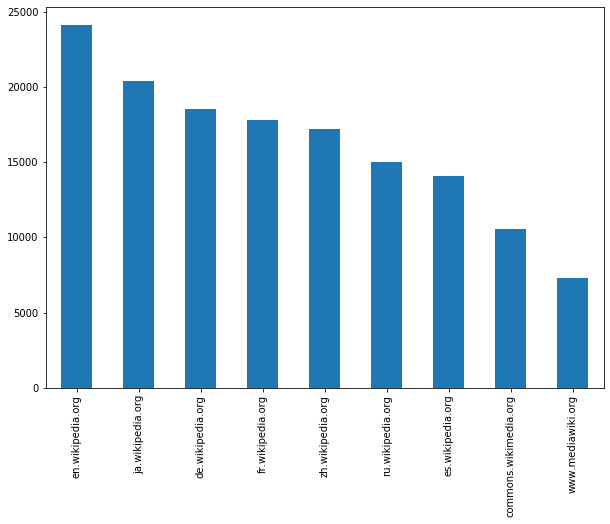

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Sub_Page.value_counts().plot(kind='bar')

plot은 각 sub page 시계열의 수를 보여준다. 위키피디아는 다른 언어로 된 서브 페이지를 가지고 있다. 
이제 Access에 초점을 두고 다시 실행해본다.

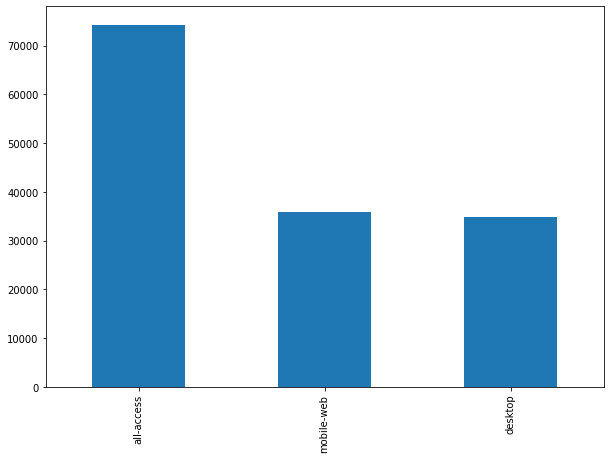

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Access.value_counts().plot(kind='bar')

모바일과 데스크탑 두가지의 접근할 수 있는 방법이 있다. 세번째 방법으로 all_access또한 있는데 모바일과 데스크탑을 합친 것이다. 

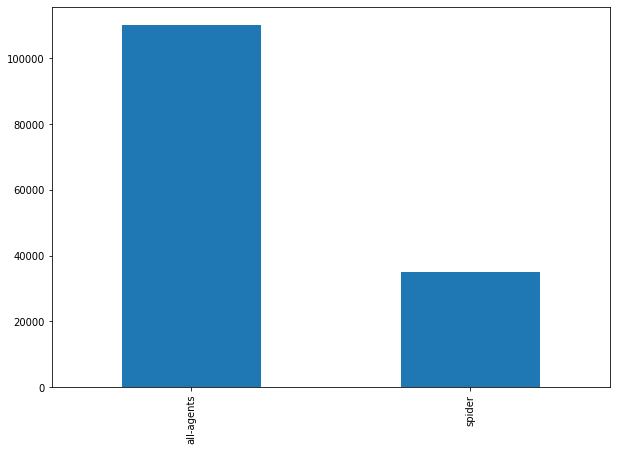

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Agent.value_counts().plot(kind='bar')

스파이더 Agent뿐만 아니라 access의 all other 타입도 있다. 전통적인 통계 모델링에선 각 글로벌 feature들의 effect를 분석하고 모델을 만들었을 것이다. 그러나 데이터가 많고 컴퓨팅 파워가 충분하면 필요없다.

이러한 경우라면 neural network는 global feature의 effect를 찾을 수 있고 그들의 interaction 속에서 새로운 features를 생성할 수 있다. 

두가지 고려사항이 있다.

1. feature의 분포가 skewed 되었나?
2. feature가 쉽게 encoded될 수 있나?

어떤 global features는 one-hot encoded되지 않는다. 위키피디아 article의 전체 데이터셋의 시계열을 생각해보면 바로 사용하는 것은 불가능하다는 것을 알 수 있다. 

### Examining the sample time series 

데이터셋을 검사해보자.
10-day rolling mean의 page view를 plot하기 위해 아래의 코드가 필요하다.

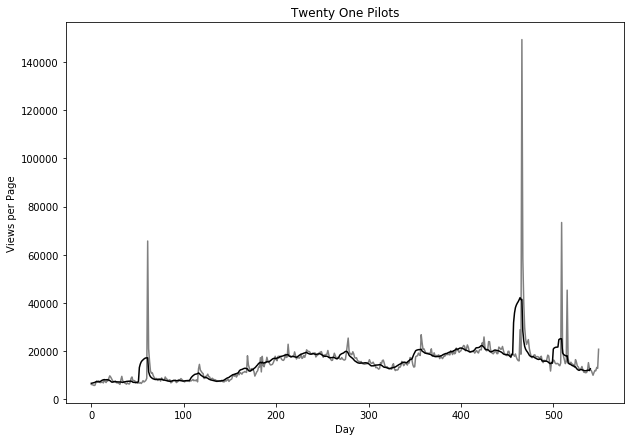

In [24]:
from matplotlib import dates

idx = 39457

window = 10


data = train.iloc[idx,0:-4]
name = train.iloc[idx,-4]
days = [r for r in range(data.shape[0] )]

fig, ax = plt.subplots(figsize=(10, 7))

plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title(name)

ax.plot(days,data.values,color='grey')
ax.plot(np.convolve(data, np.ones((window,))/window, mode='valid'),color='black')

평균을 계산하기 위해 convolve 연산을 사용했다.

모든 언어에서 Twenty One Pilots를 plot해보자.

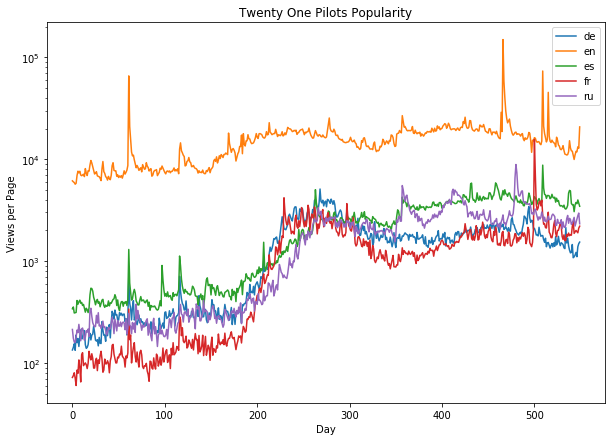

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Twenty One Pilots Popularity')
ax.set_yscale('log')
handles = []
for country in ['de','en','es','fr','ru']:
    idx= np.where((train['Subject'] == 'Twenty One Pilots') 
                  & (train['Sub_Page'] == '{}.wikipedia.org'.format(country)) 
                  & (train['Access'] == 'all-access') & (train['Agent'] == 'all-agents'))
    idx=idx[0][0]
    
    data = train.iloc[idx,0:-4]
    handle = ax.plot(days,data.values,label=country)
    handles.append(handle)

ax.legend()

시계열 간의 상관성을 볼 수 있다. 평균과 표준편차가 시간에 따라 바뀌고 있다. 200-250쯤에 평균이 급격하게 변하는 것을 볼 수 있다.

금융 분야의 시계열은 stationary하지 않다. stationary하지 않은 데이터를 다루는데 도움을 주는 몇가지 유용한 툴을 이 문제를 통해서 알아가보도록 한다.

### Why stationarity matters

많은 전통적인 경제학적 방법은 정상성을 가정한다. 이러한 이유는 추론과 가설의 테스팅이 정상성에서 더 잘 맞기 때문이다. 신경망을 사용하기 전에 데이터를 표준화시킬 필요가 있다. 주가가 1달러에서 1000달러가 됐다면 비정상시계열 데이터이고 학습하기에 매우 까다롭다. 

### Making a time series stationary

차분을 통해서 금융 데이터를 stationary로 만들 수 있다.

또 다른 방법으로 linear regression이 있다. 아래의 코드는 데이터로부터 linear trend를 없애는 것을 보여준다.

In [36]:
import statsmodels.api as sm

time = np.linspace(0, 10, 1000)
series = time
series = series + np.random.randn(1000) * 0.2
mdl = sm.OLS(time, series).fit()
trend = mdl.predict(time)

### When to ignore stationarity issues

정상성을 걱정하지 않아도 될 때가 있다. 급격한 변화를 예측할 때 이다. 예를 들어, 이전보다 위키피디아에 방문자가 그전보다 늘어나면 흥미가 증가한다고 볼 수 있다. 이러한 경우 difference를 제거하면 이러한 변화를 학습하지 못한다. 특정 비정상성은 변화를 감지하기 위해 남겨둬야 한다. 예측은 추론과 가설보다 정상성에 있어 덜 빡빡하다. 

### Fast Fourier transformations